# Analítica de datos - ejemplo de clase - comparación distintos métodos de regresión

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación

Nota: conjunto de evaluación no se utiliza en NINGUNA etapa de entrenamiento 

In [1]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from funciones_fifa import dummy_fifa, pre_exploratorio, save_fig, code_euro

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'datos/data.csv'

Xdata = pd.read_csv(csv_path)

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From']
Xdata.drop(columns = col_drop, inplace = True)


In [2]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest = train_test_split(Xdata,test_size=0.95) #fijar en 0.3 para entrenar -- 0.95 para demostrar funcionalidad del código
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

ytrain = SimpleImputer(strategy="most_frequent").fit_transform(pd.DataFrame(ytrain)).reshape(-1)
ytrain = code_euro(ytrain)

ytest = SimpleImputer(strategy="most_frequent").fit_transform(pd.DataFrame(ytest)).reshape(-1)
ytest = code_euro(ytest)


In [3]:
col_euro = ['Value','Wage'];
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB'];

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))

dummy = dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = dummy.fit_transform(Xtrain)


In [4]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 14814 to 10811
Data columns (total 81 columns):
Age                         910 non-null int64
Nationality                 910 non-null float64
Overall                     910 non-null int64
Potential                   910 non-null int64
Club                        910 non-null float64
Value                       910 non-null float64
Wage                        910 non-null float64
Special                     910 non-null int64
Preferred Foot              910 non-null float64
International Reputation    910 non-null float64
Weak Foot                   910 non-null float64
Skill Moves                 910 non-null float64
Work Rate                   910 non-null float64
Body Type                   910 non-null float64
Real Face                   910 non-null float64
Position                    910 non-null float64
Jersey Number               910 non-null float64
Joined                      910 non-null float64
Contract Valid 

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 910 samples in 0.003s...
[t-SNE] Computed neighbors for 910 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 910 / 910
[t-SNE] Mean sigma: 2.514127
[t-SNE] Computed conditional probabilities in 0.019s
[t-SNE] Iteration 50: error = 70.9223251, gradient norm = 0.3868076 (50 iterations in 0.351s)
[t-SNE] Iteration 100: error = 67.7388763, gradient norm = 0.3487018 (50 iterations in 0.300s)
[t-SNE] Iteration 150: error = 67.4760590, gradient norm = 0.3507791 (50 iterations in 0.316s)
[t-SNE] Iteration 200: error = 67.8299866, gradient norm = 0.3483125 (50 iterations in 0.322s)
[t-SNE] Iteration 250: error = 67.8487320, gradient norm = 0.3471929 (50 iterations in 0.359s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.848732
[t-SNE] KL divergence after 251 iterations: 17976931348623157081452742373170435679807056752584499659891747680315726078002853876058955863276687817154045895351438246

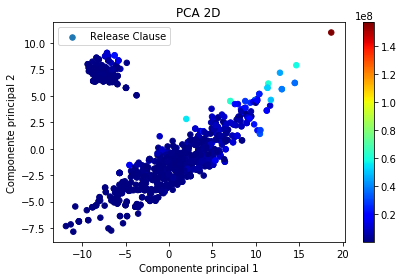

Guardando... relevancia_PCA


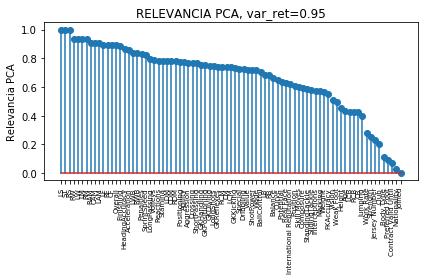

Guardando... tsne_2D


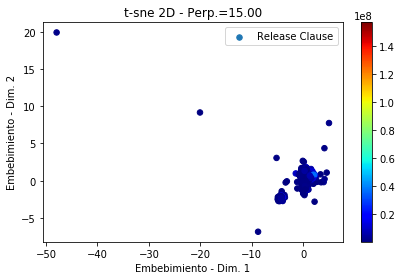

True

In [5]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = 'im2/'
pre_exploratorio(Xtrain_pre,ytrain,img_path,col_sal)

In [6]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/

steps=[[('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
        ('rep',  PCA()),
        ('reg', RandomForestRegressor())],
       [('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
        ('reg', KernelRidge())],
       [('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
        ('reg', ElasticNet())],
       [('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
        ('reg', BayesianRidge())],
      ]
parameters = [{
              'rep__n_components' : [0.8,0.9],              
              'reg__max_depth': [8,10],
              'reg__n_estimators' : [10,20],
              },
              {          
               'reg__kernel': ['poly'],
               'reg__degree' : [1,2,3],
               },
              {
               'reg__alpha': [0.01,0.1,1,10],
               'reg__l1_ratio' : [0.01,0.5,0.9],
               },
                {
               #'reg__alpha_1': [1e-6,1e-5,1e-3],
               'reg__alpha_2': [1e-6,1e-5,1e-3],
               #'reg__lambda_1': [1e-6,1e-5,1e-3],
               'reg__lambda_2': [1e-6,1e-5,1e-3],
               }
             ]

label_models = ['PRE_PCA_RanForest','PRE_RidgeReg_poly',
                'PRE_Elastic_Net','PRE_BayesianRidge']

best_model = []
filename = 'resultados/fifa_comp'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=4,cv=5,
                                scoring='neg_mean_absolute_error',verbose=10)
    grid_search.fit(Xtrain, ytrain)
    print(grid_search.cv_results_)
    #mejor modelo entrenado
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

modelo 1/4
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   41.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   59.9s
[Parallel(n_jobs=4)]: Done  38 out of  40 | elapsed:  1.1min remaining:    3.4s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  1.1min finished


{'mean_fit_time': array([4.09184828, 4.33101163, 4.06632195, 4.05794406, 3.88820271,
       3.99815483, 3.96574736, 3.95318379]), 'std_fit_time': array([0.23916511, 0.18548626, 0.09228355, 0.1353757 , 0.12297768,
       0.113342  , 0.08051206, 0.0753932 ]), 'mean_score_time': array([0.46515465, 0.50225687, 0.47333288, 0.47991643, 0.4619648 ,
       0.50008183, 0.47335997, 0.47543225]), 'std_score_time': array([0.02458338, 0.02331734, 0.01376978, 0.02677197, 0.0184048 ,
       0.03691629, 0.00990831, 0.02032958]), 'param_reg__max_depth': masked_array(data=[8, 8, 8, 8, 10, 10, 10, 10],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_reg__n_estimators': masked_array(data=[10, 10, 20, 20, 10, 10, 20, 20],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_rep__n_components': masked_array(data=[0.8, 0.9, 0.8, 0.9, 0.8, 0.9, 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:   19.3s remaining:    9.6s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   19.7s remaining:    4.9s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   25.3s finished


{'mean_fit_time': array([4.01618838, 4.09498324, 3.80827799]), 'std_fit_time': array([0.07417185, 0.07549382, 0.24246474]), 'mean_score_time': array([0.50607038, 0.52136583, 0.44760237]), 'std_score_time': array([0.04180593, 0.04258829, 0.03887975]), 'param_reg__degree': masked_array(data=[1, 2, 3],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_reg__kernel': masked_array(data=['poly', 'poly', 'poly'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg__degree': 1, 'reg__kernel': 'poly'}, {'reg__degree': 2, 'reg__kernel': 'poly'}, {'reg__degree': 3, 'reg__kernel': 'poly'}], 'split0_test_score': array([ -953455.78021978, -1713208.57782452, -1576202.79339834]), 'split1_test_score': array([  -996364.92307692,  -1302384.95879121, -30821070.12097302]), 'split2_test_score': array([ -888502.54945055, -1584675.53537088, -4471950.48302686]), 'split3_test_score': array([-1038617.89010989, 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   39.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   57.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  1.6min finished


{'mean_fit_time': array([4.05457425, 4.06649747, 4.18299136, 3.99938507, 3.973174  ,
       3.89292631, 3.97723184, 3.93005285, 4.001544  , 3.91107011,
       4.03269348, 3.93272548]), 'std_fit_time': array([0.10890735, 0.11060074, 0.0804933 , 0.15807331, 0.05811936,
       0.05207407, 0.06852447, 0.10996108, 0.08688963, 0.06953044,
       0.09259319, 0.0683506 ]), 'mean_score_time': array([0.47692404, 0.51382551, 0.54853239, 0.50246015, 0.46337371,
       0.48410306, 0.47233462, 0.475454  , 0.48643861, 0.47454276,
       0.48003087, 0.46654902]), 'std_score_time': array([0.02064759, 0.01884262, 0.04724756, 0.02208009, 0.00991535,
       0.01817041, 0.02213887, 0.01896907, 0.02187277, 0.01674176,
       0.04139799, 0.02665135]), 'param_reg__alpha': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=obj

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   40.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   58.1s
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed:  1.2min remaining:    3.2s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.3min finished


{'mean_fit_time': array([3.96700087, 4.29520407, 4.19647799, 4.25399084, 4.23341451,
       3.90794482, 3.91321092, 3.9108871 , 3.86852093]), 'std_fit_time': array([0.08059717, 0.22778081, 0.19477626, 0.12282455, 0.11950766,
       0.05050325, 0.06418063, 0.10547992, 0.33388624]), 'mean_score_time': array([0.47413044, 0.49148469, 0.4886889 , 0.51446099, 0.49061656,
       0.49108586, 0.47048907, 0.47692418, 0.45041585]), 'std_score_time': array([0.01976366, 0.01000106, 0.01352706, 0.01650953, 0.03257574,
       0.02375767, 0.03496145, 0.04339235, 0.04224757]), 'param_reg__alpha_2': masked_array(data=[1e-06, 1e-06, 1e-06, 1e-05, 1e-05, 1e-05, 0.001, 0.001,
                   0.001],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_reg__lambda_2': masked_array(data=[1e-06, 1e-05, 0.001, 1e-06, 1e-05, 0.001, 1e-06, 1e-05,
                   0.001],
             mask=[False, False,

[Pipeline(memory=None,
      steps=[('dummy_pre', dummy_fifa(cat_usr={'Nationality': ['England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Colombia', 'Japan', 'Netherlands', 'Sweden', 'China PR', 'Chile', 'Republic of Ireland', 'Mexico', 'United States', 'Poland', 'Norway', 'Saudi Arabia', 'Denmark', 'Korea...ators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False))]),
 Pipeline(memory=None,
      steps=[('dummy_pre', dummy_fifa(cat_usr={'Nationality': ['England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Colombia', 'Japan', 'Netherlands', 'Sweden', 'China PR', 'Chile', 'Republic of Ireland', 'Mexico', 'United States', 'Poland', 'Norway', 'Saudi Arabia', 'Denmark', 'Korea...reg', KernelRidge(alpha=1, coef0=1, degree=1, gamma=None, kernel='poly',
       kernel_params=None))]),
 Pipeline(memory=None,
      steps=[('dummy_pre', dummy_fifa(cat_usr={'Nationality': ['England', 'Germany', 'Spain', 'Argentina'

# Calcular rendimiento en cojunto de test

In [7]:
#%% Paso 5: evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
ytest_e = np.zeros((Xtest.shape[0],len(my_model_loaded)))
vmae = np.zeros((Xtest.shape[0],len(my_model_loaded)))
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))
    ytest_e[:,i] = my_model_loaded[i].predict(Xtest)
    vmae[:,i] = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(ytest_e[:,i]).reshape(1,-1),multioutput='raw_values')
    print('Hecho\n')


Evaluando modelo 1/4
Hecho

Evaluando modelo 2/4
Hecho

Evaluando modelo 3/4
Hecho

Evaluando modelo 4/4
Hecho



resultados/fifa_comp
Guardando... mae_testing_set


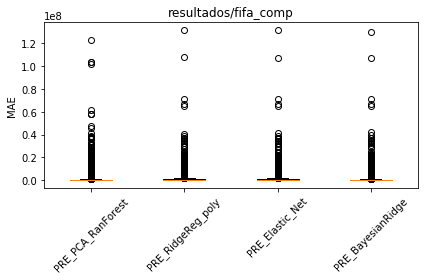

Desempeño promedio


array([ 910337.77225809, 1015773.00764583,  942390.43017247,
        856744.95061207])

In [11]:
#graficar boxplot
plt.boxplot(vmae)
print(filename)
plt.xticks(range(1,len(my_model_loaded)+1),labels=label_models,rotation=45)
plt.ylabel('MAE')
#plt.ylim([-0.01e8,0.1e8])
plt.title(filename)
save_fig(img_path,"mae_testing_set")
plt.show()
print('Desempeño promedio')
vmae.mean(axis=0)


In [9]:
my_model_loaded[2].get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('dummy_pre', dummy_fifa(cat_usr={'Nationality': ['England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Colombia', 'Japan', 'Netherlands', 'Sweden', 'China PR', 'Chile', 'Republic of Ireland', 'Mexico', 'United States', 'Poland', 'Norway', 'Saudi Arabia', 'Denmark', 'Korea...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])>